In [192]:
from utils import (adstock,decomposition,create_transformed_tables, calc_roi, decomposition_linear)
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
# Display the full statsmodels summary output as preformatted text to avoid truncation in Jupyter
from IPython.display import display, Markdown

In [193]:
# Load data from the 'dataset' sheet, range B6:CY266, with 'Date' as the date column
df_data = pd.read_excel(
    'data/mock model.xlsx',
    sheet_name='DataSet',
    usecols='B:DA',
    skiprows=5,
    nrows=261,
    parse_dates=['Date']
).set_index('Date')

# Add a random number column
df_data['random'] = np.random.rand(len(df_data))


df_var_spec_all = pd.read_excel(
    'data/mock model.xlsx',
    sheet_name='EqnSpec',
    usecols='A:h',
) #.set_index('variable')

### Create Log-Linear Model


In [194]:
df_var_spec = df_var_spec_all.copy()
df_var_spec = df_var_spec.rename(columns={'beta_log': 'beta'})
df_var_spec = df_var_spec[df_var_spec['beta'].notnull()].copy()
df_var_spec = df_var_spec.drop(columns=['beta_add'])
df_var_spec['log'] = df_var_spec['log'] == 1
df_var_spec


,variable,beta,carryover,log,group,decomp_ref,spend_variable
0,c,1.200000e+01,NaN,False,base,NaN,NaN
2,d_jan,-1.500000e-01,NaN,False,base,NaN,NaN
3,d_feb,-1.000000e-01,NaN,False,base,NaN,NaN
4,d_mar,8.000000e-02,NaN,False,base,NaN,NaN
5,d_apr,1.000000e-01,NaN,False,base,NaN,NaN
6,d_may,1.000000e-01,NaN,False,base,NaN,NaN
10,d_sep,5.000000e-02,NaN,False,base,NaN,NaN
11,d_oct,1.000000e-01,NaN,False,base,NaN,NaN
12,d_nov,1.500000e-01,NaN,False,base,NaN,NaN
13,d_dec,-2.000000e-01,NaN,False,base,NaN,NaN


In [195]:
sigma = 0.05
df_data['error'] = scipy.stats.norm.ppf(df_data['random'], loc=0, scale=sigma)

In [196]:
df_trans, df_values = create_transformed_tables(df_data, df_var_spec,True)

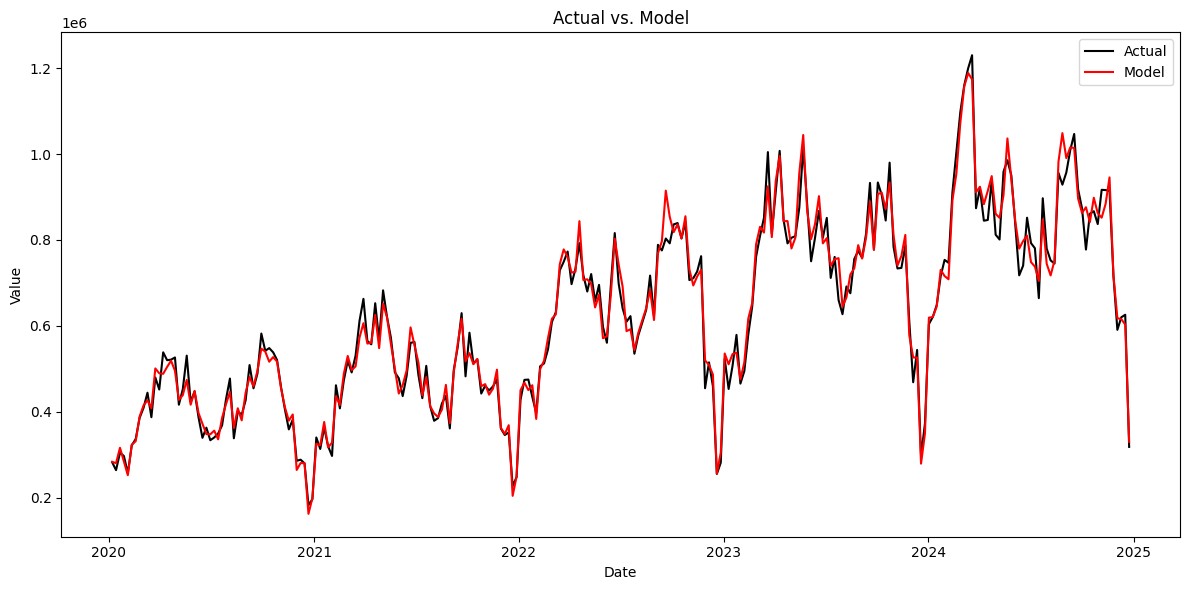

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_values.index, df_values['actual'], label='Actual', color='black')
plt.plot(df_values.index, df_values['model'], label='Model', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Model')
plt.legend()
plt.tight_layout()
plt.show()

In [198]:
df_decomp_vol = decomposition(df_var_spec,df_values)
price_col = 'price_se_xf'
df_decomp_val = df_decomp_vol.multiply(df_data[price_col], axis=0)

Check passed: True
Group sum check passed: True
Check passed: True


In [199]:
df_rois = calc_roi(df_decomp_val, df_var_spec, df_data)

In [200]:
# Interactive stacked area chart of all variables in df_decomp_vol except model, model_og, diff using plotly
import plotly.graph_objects as go
exclude_cols = ['model', 'model_og', 'diff']
area_cols = [col for col in df_decomp_vol.columns if col not in exclude_cols]
fig = go.Figure()
for col in area_cols:
    fig.add_trace(go.Scatter(x=df_decomp_vol.index, y=df_decomp_vol[col], mode='lines', stackgroup='one', name=col))
fig.update_layout(title='Stacked Area Chart of Variable Contributions (Interactive)',
                  xaxis_title='Date', yaxis_title='Contribution',
                  legend_title='Variable',
                  hovermode='x unified',
                  height=600, width=1000)
fig.show()

In [201]:
regression_vars = list(df_trans.columns)

import statsmodels.api as sm
X = df_trans[regression_vars].fillna(0)
y = np.log(df_values['actual'])
model = sm.OLS(y, X).fit()

summary_text = model.summary().as_text()
display(Markdown(f'```{summary_text}```'))

```                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actual   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     474.6
Date:                Fri, 08 Aug 2025   Prob (F-statistic):          2.98e-190
Time:                        12:13:24   Log-Likelihood:                 445.29
No. Observations:                 260   AIC:                            -820.6
Df Residuals:                     225   BIC:                            -696.0
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
c                      12.1615      1.062     11.449      0.000      10.068      14.255
d_jan                  -0.1719      0.014    -11.926      0.000      -0.200      -0.143
d_feb                  -0.0929      0.015     -6.364      0.000      -0.122      -0.064
d_mar                   0.0868      0.014      6.033      0.000       0.058       0.115
d_apr                   0.0939      0.017      5.401      0.000       0.060       0.128
d_may                   0.1070      0.014      7.629      0.000       0.079       0.135
d_sep                   0.0464      0.014      3.271      0.001       0.018       0.074
d_oct                   0.0935      0.017      5.423      0.000       0.060       0.127
d_nov                   0.1471      0.014     10.676      0.000       0.120       0.174
d_dec                  -0.2001      0.016    -12.686      0.000      -0.231      -0.169
school_easter          -0.0691      0.029     -2.415      0.017      -0.125      -0.013
school_ht_feb          -0.0639      0.035     -1.813      0.071      -0.133       0.006
school_ht_may          -0.0321      0.032     -1.008      0.315      -0.095       0.031
school_ht_oct          -0.0421      0.036     -1.184      0.238      -0.112       0.028
payday_25               0.0781      0.008     10.351      0.000       0.063       0.093
bh_ny                  -0.4910      0.026    -19.195      0.000      -0.541      -0.441
bh_xmas                -0.6412      0.026    -24.762      0.000      -0.692      -0.590
day_valentine           0.2506      0.008     32.992      0.000       0.236       0.266
ww_nat_dlta_maxtemp     0.0119      0.002      6.772      0.000       0.008       0.015
ww_nat_dlta_rain       -0.0171      0.003     -6.765      0.000      -0.022      -0.012
ww_nat_dlta_sun         0.0144      0.003      4.798      0.000       0.008       0.020
rsi_nfood_vol_sa        0.9020      0.232      3.889      0.000       0.445       1.359
dist_xf                 1.2029      0.198      6.067      0.000       0.812       1.594
price_se_xf            -1.6328      0.144    -11.358      0.000      -1.916      -1.350
prom_tft                0.1575      0.009     17.933      0.000       0.140       0.175
pos_fsdu                0.0841      0.011      7.869      0.000       0.063       0.105
m_wow_tv             1.481e-07   5.05e-08      2.931      0.004    4.85e-08    2.48e-07
m_wow_olv            1.796e-07   1.89e-07      0.949      0.344   -1.93e-07    5.53e-07
m_wow_social         1.199e-06   6.09e-07      1.969      0.050   -9.57e-10     2.4e-06
m_amaze_tot          7.274e-08    1.6e-08      4.559      0.000    4.13e-08    1.04e-07
m_celeb_tv           1.366e-07   5.25e-08      2.605      0.010    3.33e-08     2.4e-07
m_celeb_outdoor      1.026e-07   7.17e-08      1.430      0.154   -3.87e-08    2.44e-07
m_celeb_display     -3.565e-07   2.93e-07     -1.218      0.225   -9.33e-07     2.2e-07
comp_lor_tot        -3.253e-08   2.07e-08     -1.569      0.118   -7.34e-08    8.31e-09
comp_no7_tot        -3.353e-08   2.18e-08     -1.536      0.126   -7.66e-08    9.49e-09
==============================================================================
Omnibus:                        3.988   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                3.892
Skew:                          -0.300   Prob(JB):                        0.143
Kurtosis:                       2.997   Cond. No.                     1.48e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+08. This might indicate that there are
strong multicollinearity or other numerical problems.```

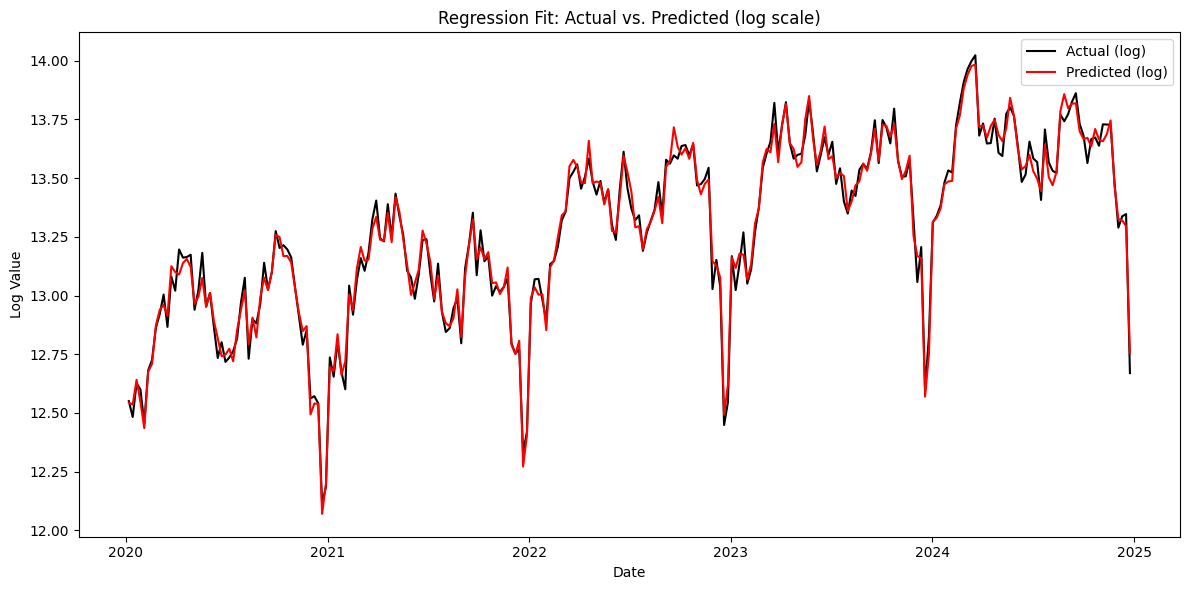

In [202]:
# Chart the fit of the regression: actual vs. predicted
y_pred = model.predict(sm.add_constant(df_trans[regression_vars].fillna(0)))
plt.figure(figsize=(12, 6))
plt.plot(df_values.index, y, label='Actual (log)', color='black')
plt.plot(df_values.index, y_pred, label='Predicted (log)', color='red', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Log Value')
plt.title('Regression Fit: Actual vs. Predicted (log scale)')
plt.legend()
plt.tight_layout()
plt.show()

In [203]:
# coefs = pd.Series(model.params, index=model.params.index)
df_var_spec_est = df_var_spec.copy()
df_var_spec_est['beta'] = df_var_spec_est['variable'].map(model.params)


In [204]:
df_trans_est, df_values_est = create_transformed_tables(df_data, df_var_spec_est, True)

df_decomp_vol_est = decomposition(df_var_spec_est,df_values_est)
df_decomp_val_est = df_decomp_vol_est.multiply(df_data[price_col], axis=0)
df_rois_est = calc_roi(df_decomp_val_est, df_var_spec_est, df_data)

Check passed: True
Group sum check passed: True
Check passed: True


In [ ]:
def merge_rois_with_percent_change(df_rois, df_rois_est):
    """Merge ROI DataFrames on 'variable', add 'roi (est)', and compute % change.

    Args:
        df_rois (pd.DataFrame): Actual ROI table with columns ['variable', 'roi', ...].
        df_rois_est (pd.DataFrame): Estimated ROI table with columns ['variable', 'roi', ...].

    Returns:
        pd.DataFrame: Merged DataFrame with 'roi (est)' and '% change (est/actual)'.
    """
    merged = df_rois.copy()
    if 'roi' in df_rois_est.columns:
        merged = merged.merge(
            df_rois_est[['variable', 'roi']],
            on='variable',
            how='left',
            suffixes=('', '_est'),
        )
        merged = merged.rename(columns={'roi_est': 'roi (est)'})
    else:
        print("roi column not found in df_rois_est")

    def _to_float(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, str):
            try:
                return float(x.replace(',', ''))
            except Exception:
                return np.nan
        try:
            return float(x)
        except Exception:
            return np.nan

    def pct_change(row):
        actual = _to_float(row.get('roi'))
        est = _to_float(row.get('roi (est)'))
        if pd.notnull(actual) and pd.notnull(est) and actual != 0:
            return f"{100 * (est - actual) / actual:.2f}%"
        return ''

    merged['% change (est/actual)'] = merged.apply(pct_change, axis=1)
    return merged

# Use the function and keep the same downstream variable name
df_rois_merged = merge_rois_with_percent_change(df_rois, df_rois_est)
df_rois_merged

,variable,value,spend_sum,roi,roi (est),% change (est/actual)
0,m_wow_tv,"4,471,876","2,699,491",1.66,2.06,24.10%
1,m_wow_olv,"1,923,657","947,317",2.03,1.84,-9.36%
2,m_wow_social,"497,480","121,919",4.08,9.79,139.95%
3,m_amaze_tot,"10,117,907","7,929,905",1.28,1.04,-18.75%
4,m_celeb_tv,"8,590,703","2,828,021",3.04,3.45,13.49%
5,m_celeb_outdoor,"3,712,733","1,290,619",2.88,2.45,-14.93%
6,m_celeb_display,"3,941,598","1,586,718",2.48,-4.75,-291.53%
7,Total,"33,255,954","17,403,991",1.91,1.27,-33.51%


In [206]:
# Save key DataFrames as CSVs in the results folder
import os
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

df_data.to_csv(os.path.join(results_dir, 'data.csv'))
df_var_spec.to_csv(os.path.join(results_dir, 'var_spec.csv'), index=False)
df_var_spec_est.to_csv(os.path.join(results_dir, 'var_spec_est.csv'), index=False)
df_decomp_vol.to_csv(os.path.join(results_dir, 'decomp.csv'))
df_decomp_vol_est.to_csv(os.path.join(results_dir, 'decomp_est.csv'))
df_rois_merged.to_csv(os.path.join(results_dir, 'Rois.csv'), index=False)

### Additive model


In [207]:
## change svol_xf to svol_xf_add
df_data['svol_xf'] = df_data['svol_xf_add']

df_var_spec = df_var_spec_all.copy()
df_var_spec = df_var_spec.rename(columns={'beta_add': 'beta'})
df_var_spec = df_var_spec[df_var_spec['beta'].notnull() & df_var_spec['beta']!=0].copy()
df_var_spec = df_var_spec.drop(columns=['beta_log'])
df_var_spec['log'] = None
df_var_spec


,variable,beta,carryover,log,group,decomp_ref,spend_variable
0,c,400000.0,NaN,None,base,NaN,NaN
2,d_jan,-60000.0,NaN,None,base,NaN,NaN
3,d_feb,-40000.0,NaN,None,base,NaN,NaN
4,d_mar,32000.0,NaN,None,base,NaN,NaN
5,d_apr,40000.0,NaN,None,base,NaN,NaN
6,d_may,40000.0,NaN,None,base,NaN,NaN
10,d_sep,20000.0,NaN,None,base,NaN,NaN
11,d_oct,40000.0,NaN,None,base,NaN,NaN
12,d_nov,60000.0,NaN,None,base,NaN,NaN
13,d_dec,-80000.0,NaN,None,base,NaN,NaN


In [208]:
df_data.head()
sigma = 0.05
df_data['error'] = scipy.stats.norm.ppf(df_data['random'], loc=0, scale=sigma)
# df_data['error']=0

In [209]:
df_trans, df_values = create_transformed_tables(df_data, df_var_spec,False)


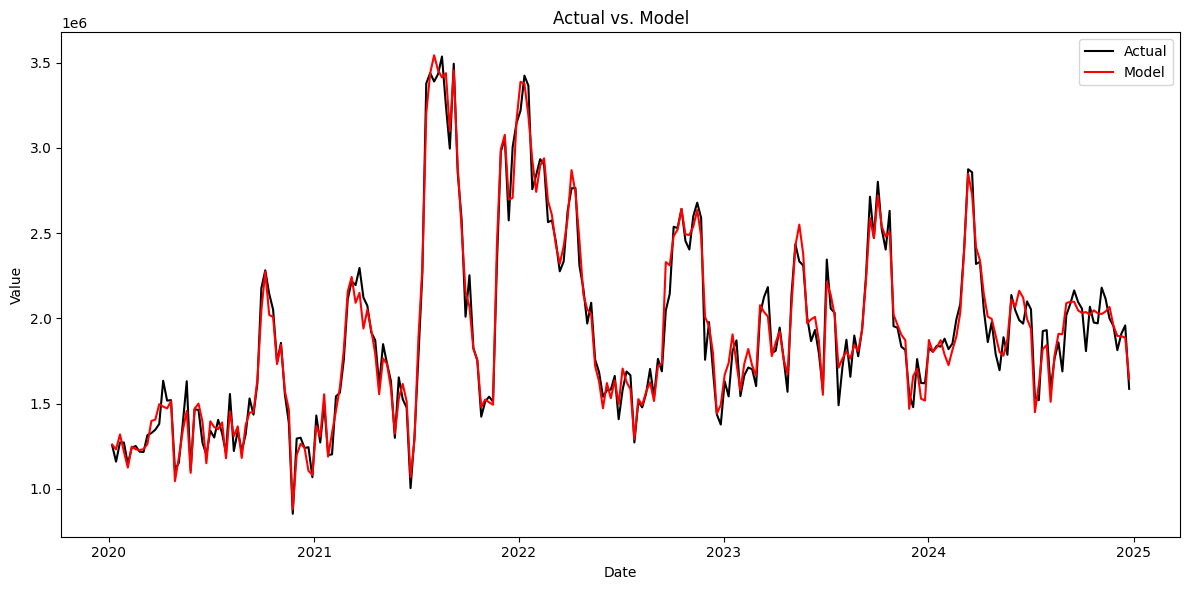

In [210]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_values.index, df_values['actual'], label='Actual', color='black')
plt.plot(df_values.index, df_values['model'], label='Model', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Model')
plt.legend()
plt.tight_layout()
plt.show()

In [211]:
df_decomp_vol = decomposition_linear(df_var_spec,df_values)
price_col = 'price_se_xf'
df_decomp_val = df_decomp_vol.multiply(df_data[price_col], axis=0)

Check passed: True
Group sum check passed: True


In [212]:
df_rois = calc_roi(df_decomp_val, df_var_spec, df_data)


In [213]:
# Interactive stacked area chart of all variables in df_decomp_vol except model, model_og, diff using plotly
import plotly.graph_objects as go
exclude_cols = ['model', 'model_og', 'diff']
area_cols = [col for col in df_decomp_vol.columns if col not in exclude_cols]
fig = go.Figure()
for col in area_cols:
    fig.add_trace(go.Scatter(x=df_decomp_vol.index, y=df_decomp_vol[col], mode='lines', stackgroup='one', name=col))
fig.update_layout(title='Stacked Area Chart of Variable Contributions (Interactive)',
                  xaxis_title='Date', yaxis_title='Contribution',
                  legend_title='Variable',
                  hovermode='x unified',
                  height=600, width=1000)
fig.show()

In [214]:
regression_vars = list(df_trans.columns)

import statsmodels.api as sm
X = df_trans[regression_vars].fillna(0)
y = df_values['actual']
model = sm.OLS(y, X).fit()

summary_text = model.summary().as_text()
display(Markdown(f'```{summary_text}```'))

```                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actual   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     277.4
Date:                Fri, 08 Aug 2025   Prob (F-statistic):          1.45e-164
Time:                        12:13:25   Log-Likelihood:                -3313.3
No. Observations:                 260   AIC:                             6697.
Df Residuals:                     225   BIC:                             6821.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
c                   -4.123e+05   5.44e+05     -0.758      0.449   -1.48e+06     6.6e+05
d_jan               -1.027e+05   2.73e+04     -3.756      0.000   -1.57e+05   -4.88e+04
d_feb               -2.672e+04   2.77e+04     -0.966      0.335   -8.12e+04    2.78e+04
d_mar                4.938e+04   2.72e+04      1.818      0.070   -4148.148    1.03e+05
d_apr                2.429e+04    3.3e+04      0.737      0.462   -4.07e+04    8.93e+04
d_may                4.383e+04   2.66e+04      1.647      0.101   -8612.999    9.63e+04
d_sep                7756.1571   2.69e+04      0.288      0.773   -4.53e+04    6.08e+04
d_oct                2.485e+04   3.27e+04      0.760      0.448   -3.96e+04    8.93e+04
d_nov                5.469e+04   2.61e+04      2.093      0.037    3195.515    1.06e+05
d_dec               -9.037e+04   2.99e+04     -3.020      0.003   -1.49e+05   -3.14e+04
school_easter       -5.652e+04   5.43e+04     -1.041      0.299   -1.64e+05    5.05e+04
school_ht_feb       -4.407e+04   6.68e+04     -0.659      0.510   -1.76e+05    8.77e+04
school_ht_may        1.927e+04   6.05e+04      0.318      0.750      -1e+05    1.39e+05
school_ht_oct        3450.9113   6.74e+04      0.051      0.959   -1.29e+05    1.36e+05
payday_25            2.931e+04   1.43e+04      2.048      0.042    1104.013    5.75e+04
bh_ny               -1.761e+05   4.85e+04     -3.629      0.000   -2.72e+05   -8.05e+04
bh_xmas             -1.616e+05   4.91e+04     -3.290      0.001   -2.58e+05   -6.48e+04
day_valentine        9.847e+04   1.41e+04      6.961      0.000    7.06e+04    1.26e+05
ww_nat_dlta_maxtemp  6639.4373   3326.819      1.996      0.047      83.730    1.32e+04
ww_nat_dlta_rain    -1635.7439   4789.116     -0.342      0.733   -1.11e+04    7801.514
ww_nat_dlta_sun       1.35e+04   5702.257      2.368      0.019    2267.771    2.47e+04
rsi_nfood_vol_sa     9974.9620   4006.843      2.489      0.014    2079.224    1.79e+04
dist_xf              7.457e+05   4.85e+05      1.538      0.125    -2.1e+05     1.7e+06
price_se_xf          1.999e+04   2.86e+04      0.698      0.486   -3.64e+04    7.64e+04
prom_tft             7.631e+04   1.67e+04      4.580      0.000    4.35e+04    1.09e+05
pos_fsdu             9545.4484   2.03e+04      0.471      0.638   -3.04e+04    4.95e+04
m_wow_tv                1.0532      0.095     11.043      0.000       0.865       1.241
m_wow_olv               0.9457      0.359      2.636      0.009       0.239       1.653
m_wow_social            2.4556      1.151      2.133      0.034       0.187       4.724
m_amaze_tot             1.9627      0.030     65.199      0.000       1.903       2.022
m_celeb_tv              2.0484      0.100     20.586      0.000       1.852       2.244
m_celeb_outdoor         1.9744      0.136     14.508      0.000       1.706       2.243
m_celeb_display         0.8347      0.556      1.501      0.135      -0.261       1.931
comp_lor_tot           -0.5340      0.039    -13.571      0.000      -0.612      -0.456
comp_no7_tot           -0.5176      0.041    -12.500      0.000      -0.599      -0.436
==============================================================================
Omnibus:                        1.268   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.531   Jarque-Bera (JB):                1.170
Skew:                          -0.164   Prob(JB):                        0.557
Kurtosis:                       3.002   Cond. No.                     4.73e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.73e+07. This might indicate that there are
strong multicollinearity or other numerical problems.```